# Background

In the world of online streaming, user satisfaction and engagement are critical metrics for the success of a movie recommendation system. A well-designed recommendation algorithm can significantly enhance user experience by suggesting movies that align with their preferences, leading to higher platform retention and usage. Recommendation systems face the challenge of balancing exploration (discovering new movies) with exploitation (recommending known favourites) to maximize user satisfaction over time.


# Scenario

Imagine a leading online movie streaming platform, TrendMovie Inc., that aims to become the go-to destination for personalized movie recommendations. The platform features a vast collection of movies catering to diverse audiences. TrendMovie Inc. wants to optimize its recommendation strategy to deliver maximum user satisfaction while maintaining a high level of engagement. Each movie recommendation is treated as an interaction with the user, and their feedback is used to refine the recommendation strategy dynamically.


# Objective

Your objective is to design and implement a recommendation system using Multi-Armed Bandit (MAB) algorithms to maximize cumulative user satisfaction. The system should dynamically allocate recommendations by learning user preferences in real-time, striking the right balance between exploration and exploitation.


# Dataset

The dataset contains user ratings for a variety of movies. Key columns in the dataset include:
*   **User ID:** A unique identifier for each user.
*   **Movie ID:** A unique identifier for each.
*   **Rating:** A score provided by the user for a movie (on a scale of 1 to 5).
*   **Timestamp:** The time when the rating was given (optional for this assignment).

***Link for accessing dataset:***
https://drive.google.com/file/d/1gfobhqlVCw8Oo52JCiYpEBGhG5k7cWBr/view?usp=drive_link


# Environment Details

**Arms:** Each movie represents an "arm" in the MAB framework. The probability of a movie being liked by a user is initially unknown and will be estimated based on user feedback during the interactions.
For example:

Arm 1: Movie A

Arm 2: Movie B

Arm 3: Movie C

... and so on, for all movies in the dataset.

**Reward Function:**
The reward function is defined based on user ratings:

***Reward = 1:*** The user rates the movie high star (e.g., 4 or 5 stars).

***Reward = 0:*** The user rates the movie low star (e.g., 1, 2, or 3 stars).


**Assumptions:**

Run simulations for 1000 iterations for each policy


# Requirements and Deliverables:
Implement the Multi-Arm Bandit Problem for the given above scenario for all the below mentioned policy methods.

### Initialize constants

In [17]:
# Constants
random_policy_rewards = []
greedy_policy_rewards = []
epsilon_greedy_rewards = []
ucb_policy_rewards = []


# Initialize value function and policy

# Load Dataset

In [18]:
# Code for Dataset loading and print dataset statistics
#-----write your code below this line---------
import pandas as pd

# Load the dataset
# Replace 'movie_ratings.csv' with the actual file path of your dataset
file_path = 'TrendMovie.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
print("Dataset Head:")
print(df.head())

# Dataset Structure: Assuming it has the columns:
# 'userId', 'movieId', 'rating', and  'timestamp'

# Check for missing values
print("\nChecking for missing values:")
print(df.isnull().sum())

# Drop missing values if any
df.dropna(inplace=True)

# Convert 'Rating' to binary rewards
# Reward = 1 if Rating >= 4, otherwise Reward = 0
df['Reward'] = df['rating'].apply(lambda x: 1 if x >= 4 else 0)

# Create mappings for movies (arms)
unique_movies = df['movieId'].unique()
movie_to_arm = {movie: arm for arm, movie in enumerate(unique_movies)}
arm_to_movie = {arm: movie for movie, arm in movie_to_arm.items()}

# Map Movie IDs to arm indices in the dataset
df['Arm'] = df['movieId'].map(movie_to_arm)

# Display the preprocessed DataFrame
print("\nPreprocessed DataFrame:")
print(df.head())

# Save the preprocessed data for future use
processed_file_path = 'processed_movie_ratings.csv'
df.to_csv(processed_file_path, index=False)

# Display the mappings
print("\nMovie to Arm Mapping:")
print(movie_to_arm)

print("\nArm to Movie Mapping:")
print(arm_to_movie)



Dataset Head:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

Checking for missing values:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Preprocessed DataFrame:
   userId  movieId  rating  timestamp  Reward  Arm
0       1        1     4.0  964982703       1    0
1       1        3     4.0  964981247       1    1
2       1        6     4.0  964982224       1    2
3       1       47     5.0  964983815       1    3
4       1       50     5.0  964982931       1    4

Movie to Arm Mapping:
{np.int64(1): 0, np.int64(3): 1, np.int64(6): 2, np.int64(47): 3, np.int64(50): 4, np.int64(70): 5, np.int64(101): 6, np.int64(110): 7, np.int64(151): 8, np.int64(157): 9, np.int64(163): 10, np.int64(216): 11, np.int64(223): 12, np.int64(231): 13, np.int64(235): 14, np.int64(260): 15, np.int64(296): 

# Design a Movie Environment

In [66]:
# Code for Dataset loading and print dataset statistics along with reward function
#-----write your code below this line---------

import numpy as np
import pandas as pd

class MovieEnvironment:
    def __init__(self, file_path):
        """
        Initialize the environment with the dataset file path.
        """
        self.file_path = file_path
        self.df = None  # To store the dataset
        self.num_arms = 0  # Number of unique arms/movies
        self.movie_to_arm = {}  # Mapping from Movie ID to arm index
        self.arm_to_movie = {}  # Mapping from arm index to Movie ID

    def load_dataset(self):
        """
        Load the dataset from the file path.
        """
        try:
            self.df = pd.read_csv(self.file_path)
            print("Dataset loaded successfully.")
        except Exception as e:
            print(f"Error loading dataset: {e}")

    def print_statistics(self):
        """
        Print dataset statistics.
        """
        if self.df is None:
            print("Dataset not loaded. Please load the dataset first.")
            return
        
        print("\nDataset Statistics:")
        print(self.df)
        print(f"Number of Users: {self.df['userId'].nunique()}")
        print(f"Number of Movies: {self.df['movieId'].nunique()}")
        print(f"Number of Ratings: {len(self.df)}")
        print(f"Average Rating: {self.df['rating'].mean():.2f}")
        print(f"Rating Distribution:\n{self.df['rating'].value_counts().sort_index()}")

    def define_reward_function(self):
        """
        Define a reward function based on ratings and add a Reward column to the dataset.
        Reward = 1 if Rating >= 4, otherwise Reward = 0.
        """
        if self.df is None:
            print("Dataset not loaded. Please load the dataset first.")
            return
        
        self.df['Reward'] = self.df['rating'].apply(lambda x: 1 if x >= 4 else 0)

        # Create mappings for Movie IDs to arms
        unique_movies = self.df['movieId'].unique()
        self.movie_to_arm = {movie: arm for arm, movie in enumerate(unique_movies)}
        self.arm_to_movie = {arm: movie for movie, arm in self.movie_to_arm.items()}
        self.num_arms = len(unique_movies)

        # Map Movie IDs to arm indices in the dataset
        self.df['Arm'] = self.df['movieId'].map(self.movie_to_arm)
        print(f"Reward function defined with {self.num_arms} arms.")
        
        self.num_arms = self.df['movieId'].nunique()
        reward_distribution = self.df['Reward'].value_counts(normalize=True)
        
        print("\nReward Statistics:")
        print(self.df)
        print(f"Percentage of Rewards (1): {reward_distribution.get(1, 0) * 100:.2f}%")
        print(f"Percentage of Rewards (0): {reward_distribution.get(0, 0) * 100:.2f}%")
        

    def simulate_interaction(self, arm):
        """
        Simulate user feedback by sampling a reward for the given arm.
        If no data is found for the arm, return a default reward of 0.
        """
        if self.df is None:
            print("Dataset not loaded. Please load the dataset first.")
            return 0

        # Convert arm index to Movie ID
        movie_id = self.arm_to_movie.get(arm, None)
        if movie_id is None:
            print(f"No mapping found for Arm: {arm}")
            return 0

        # Filter rows for the selected movie ID
        sampled_rows = self.df[self.df['movieId'] == movie_id]
        if sampled_rows.empty:
            print(f"No data found for Movie ID: {movie_id}")
            return 0

        # Randomly sample a reward from the filtered rows
        sampled_row = sampled_rows.sample(1)
        # print(f"\nArm {arm} : Reward -> {sampled_row['Reward'].values[0]}")
        return sampled_row['Reward'].values[0]


# Create an instance of MovieEnvironment
env = MovieEnvironment('TrendMovie.csv')

# Load dataset
env.load_dataset()

# Print dataset statistics
env.print_statistics()

# Define the reward function
env.define_reward_function()

Dataset loaded successfully.

Dataset Statistics:
        userId  movieId  rating   timestamp
0            1        1     4.0   964982703
1            1        3     4.0   964981247
2            1        6     4.0   964982224
3            1       47     5.0   964983815
4            1       50     5.0   964982931
...        ...      ...     ...         ...
100831     610   166534     4.0  1493848402
100832     610   168248     5.0  1493850091
100833     610   168250     5.0  1494273047
100834     610   168252     5.0  1493846352
100835     610   170875     3.0  1493846415

[100836 rows x 4 columns]
Number of Users: 610
Number of Movies: 9724
Number of Ratings: 100836
Average Rating: 3.50
Rating Distribution:
rating
0.5     1370
1.0     2811
1.5     1791
2.0     7551
2.5     5550
3.0    20047
3.5    13136
4.0    26818
4.5     8551
5.0    13211
Name: count, dtype: int64
Reward function defined with 9724 arms.

Reward Statistics:
        userId  movieId  rating   timestamp  Reward   Arm
0 

# Using Random Policy
Implement a random policy for movie recommendations and print each iteration. (Mandatory)

In [67]:
#  run the environment with an agent that is guided by a random policy
#-----write your code below this line---------

class RandomAgent:
    def __init__(self, num_arms):
        """
        Initialize the random agent with the number of arms.
        """
        self.num_arms = num_arms
        self.cumulative_reward = 0  # Track cumulative reward
        self.cumulative_rewards = []  # Track cumulative rewards over iterations

    def select_action(self):
        """
        Randomly select an arm.
        """
        return np.random.randint(0, self.num_arms)

    def update_rewards(self, reward):
        """
        Update the cumulative reward with the given reward.
        """
        self.cumulative_reward += reward
        self.cumulative_rewards.append(self.cumulative_reward)


# 1. Initialize the environment
env = MovieEnvironment('TrendMovie.csv')
env.load_dataset()
env.define_reward_function()

# 2. Initialize the random agent
agent = RandomAgent(num_arms=env.num_arms)

# 3. Run the simulation
num_iterations = 1000
for _ in range(num_iterations):
    # Agent selects an action (arm)
    selected_arm = agent.select_action()

    # Environment provides a reward for the selected arm
    reward = env.simulate_interaction(selected_arm)

    # Agent updates its cumulative reward
    agent.update_rewards(reward)

# Print the total cumulative reward
random_policy_rewards = agent.cumulative_rewards
print(f"\nTotal Cumulative Reward after {num_iterations} iterations: {agent.cumulative_reward}")


Dataset loaded successfully.
Reward function defined with 9724 arms.

Reward Statistics:
        userId  movieId  rating   timestamp  Reward   Arm
0            1        1     4.0   964982703       1     0
1            1        3     4.0   964981247       1     1
2            1        6     4.0   964982224       1     2
3            1       47     5.0   964983815       1     3
4            1       50     5.0   964982931       1     4
...        ...      ...     ...         ...     ...   ...
100831     610   166534     4.0  1493848402       1  3120
100832     610   168248     5.0  1493850091       1  2035
100833     610   168250     5.0  1494273047       1  3121
100834     610   168252     5.0  1493846352       1  1392
100835     610   170875     3.0  1493846415       0  2873

[100836 rows x 6 columns]
Percentage of Rewards (1): 48.18%
Percentage of Rewards (0): 51.82%

Total Cumulative Reward after 1000 iterations: 383


# Using Greedy Policy
Implement a greedy policy that always recommends the movie with the highest estimated reward and print each iteration. (Mandatory)

In [68]:
#  run the environment with an agent that is guided by a greedy policy
#-----write your code below this line---------

class GreedyAgent:
    def __init__(self, num_arms):
        """
        Initialize the greedy agent with the number of arms.
        """
        self.num_arms = num_arms
        self.q_values = np.zeros(num_arms)  # Estimated value of each arm
        self.arm_counts = np.zeros(num_arms)  # Number of times each arm has been selected
        self.cumulative_reward = 0  # Track cumulative reward
        self.cumulative_rewards = []  # Track cumulative rewards over iterations

    def select_action(self):
        """
        Select the arm with the highest estimated reward (break ties randomly).
        """
        return np.argmax(self.q_values)

    def update_rewards(self, arm, reward):
        """
        Update the estimated reward for the selected arm.
        """
        self.arm_counts[arm] += 1
        n = self.arm_counts[arm]
        self.q_values[arm] += (reward - self.q_values[arm]) / n
        self.cumulative_reward += reward
        self.cumulative_rewards.append(self.cumulative_reward)

# Example Usage
# 1. Initialize the environment
env = MovieEnvironment('TrendMovie.csv')
env.load_dataset()
env.define_reward_function()

# 2. Initialize the greedy agent
agent = GreedyAgent(num_arms=env.num_arms)

# 3. Run the simulation
num_iterations = 1000
for _ in range(num_iterations):
    # Agent selects an action (arm) based on the greedy policy
    selected_arm = agent.select_action()

    # Environment provides a reward for the selected arm
    reward = env.simulate_interaction(selected_arm)

    # Agent updates its reward estimates
    agent.update_rewards(selected_arm, reward)

# Print the total cumulative reward
greedy_policy_rewards = agent.cumulative_rewards
print(f"\nTotal Cumulative Reward after {num_iterations} iterations: {agent.cumulative_reward}")
print("\nFinal Q-Values (Estimated Rewards) for Each Arm:")
print(agent.q_values)


Dataset loaded successfully.
Reward function defined with 9724 arms.

Reward Statistics:
        userId  movieId  rating   timestamp  Reward   Arm
0            1        1     4.0   964982703       1     0
1            1        3     4.0   964981247       1     1
2            1        6     4.0   964982224       1     2
3            1       47     5.0   964983815       1     3
4            1       50     5.0   964982931       1     4
...        ...      ...     ...         ...     ...   ...
100831     610   166534     4.0  1493848402       1  3120
100832     610   168248     5.0  1493850091       1  2035
100833     610   168250     5.0  1494273047       1  3121
100834     610   168252     5.0  1493846352       1  1392
100835     610   170875     3.0  1493846415       0  2873

[100836 rows x 6 columns]
Percentage of Rewards (1): 48.18%
Percentage of Rewards (0): 51.82%

Total Cumulative Reward after 1000 iterations: 662

Final Q-Values (Estimated Rewards) for Each Arm:
[0.662 0.    0.   

# Using Epsilon-Greedy Policy
Implement the epsilon-greedy policy, where with probability ε you explore (recommend a random movie) and with probability (1-ε) you exploit (recommend the best-known movie). Try with ε =0.1, 0.2, 0.5 and print each iteration. What value of ε yields the best performance? (Mandatory)

In [69]:
#  run the environment with an agent that is guided by a epsilon-greedy policy
#-----write your code below this line---------

class EpsilonGreedyAgent:
    def __init__(self, num_arms, epsilon):
        """
        Initialize the epsilon-greedy agent with the number of arms and epsilon value.
        """
        self.num_arms = num_arms
        self.epsilon = epsilon  # Probability of exploration
        self.q_values = np.zeros(num_arms)  # Estimated value of each arm
        self.arm_counts = np.zeros(num_arms)  # Number of times each arm has been selected
        self.cumulative_reward = 0  # Track cumulative reward
        self.cumulative_rewards = []  # Track cumulative rewards over iterations

    def select_action(self):
        """
        Select an arm using epsilon-greedy policy.
        """
        if np.random.random() < self.epsilon:
            # Explore: Select a random arm
            return np.random.randint(0, self.num_arms)
        else:
            # Exploit: Select the arm with the highest estimated reward
            return np.argmax(self.q_values)

    def update_rewards(self, arm, reward):
        """
        Update the estimated reward for the selected arm.
        """
        self.arm_counts[arm] += 1
        n = self.arm_counts[arm]
        self.q_values[arm] += (reward - self.q_values[arm]) / n
        self.cumulative_reward += reward
        self.cumulative_rewards.append(self.cumulative_reward)

# Example Usage
# 1. Initialize the environment
env = MovieEnvironment('TrendMovie.csv')
env.load_dataset()
env.define_reward_function()

# Run the simulation for different epsilon values
epsilons = [0.1, 0.2, 0.5]
num_iterations = 1000

for epsilon in epsilons:
    print(f"\nRunning simulation with ε = {epsilon}")
    
    # Initialize the epsilon-greedy agent
    agent = EpsilonGreedyAgent(num_arms=env.num_arms, epsilon=epsilon)
    
    # Run the simulation
    for _ in range(num_iterations):
        # Agent selects an action (arm) based on epsilon-greedy policy
        selected_arm = agent.select_action()
        
        # Environment provides a reward for the selected arm
        reward = env.simulate_interaction(selected_arm)
        
        # Agent updates its reward estimates
        agent.update_rewards(selected_arm, reward)

    
    
    # Print the total cumulative reward
    epsilon_greedy_rewards = agent.cumulative_rewards
    print(f"Total Cumulative Reward after {num_iterations} iterations: {agent.cumulative_reward}")
    print(f"Final Q-Values (Estimated Rewards) for Each Arm:")
    print(agent.q_values)


Dataset loaded successfully.
Reward function defined with 9724 arms.

Reward Statistics:
        userId  movieId  rating   timestamp  Reward   Arm
0            1        1     4.0   964982703       1     0
1            1        3     4.0   964981247       1     1
2            1        6     4.0   964982224       1     2
3            1       47     5.0   964983815       1     3
4            1       50     5.0   964982931       1     4
...        ...      ...     ...         ...     ...   ...
100831     610   166534     4.0  1493848402       1  3120
100832     610   168248     5.0  1493850091       1  2035
100833     610   168250     5.0  1494273047       1  3121
100834     610   168252     5.0  1493846352       1  1392
100835     610   170875     3.0  1493846415       0  2873

[100836 rows x 6 columns]
Percentage of Rewards (1): 48.18%
Percentage of Rewards (0): 51.82%

Running simulation with ε = 0.1
Total Cumulative Reward after 1000 iterations: 921
Final Q-Values (Estimated Rewards) f

# Using UCB
Implement the UCB algorithm for movie recommendations and print each iteration. (Mandatory)

In [70]:
#  run the environment with an agent that is guided by a UCB
#-----write your code below this line---------

class UCBAgent:
    def __init__(self, num_arms):
        """
        Initialize the UCB agent with the number of arms.
        """
        self.num_arms = num_arms
        self.q_values = np.zeros(num_arms)  # Estimated value of each arm
        self.arm_counts = np.zeros(num_arms)  # Number of times each arm has been selected
        self.total_pulls = 0  # Total number of arm pulls
        self.cumulative_reward = 0  # Track cumulative reward
        self.cumulative_rewards = []  # Track cumulative rewards over iterations

    def select_action(self):
        """
        Select an arm using the UCB policy.
        """
        self.total_pulls += 1
        
        # Initialize each arm to be selected at least once
        for arm in range(self.num_arms):
            if self.arm_counts[arm] == 0:
                return arm
        
        # Calculate UCB values for each arm
        ucb_values = np.zeros(self.num_arms)
        for arm in range(self.num_arms):
            avg_reward = self.q_values[arm]
            confidence_bound = math.sqrt((2 * math.log(self.total_pulls)) / self.arm_counts[arm])
            ucb_values[arm] = avg_reward + confidence_bound
        
        # Select the arm with the highest UCB value
        return np.argmax(ucb_values)

    def update_rewards(self, arm, reward):
        """
        Update the estimated reward for the selected arm.
        """
        self.arm_counts[arm] += 1
        n = self.arm_counts[arm]
        self.q_values[arm] += (reward - self.q_values[arm]) / n
        self.cumulative_reward += reward
        self.cumulative_rewards.append(self.cumulative_reward)

# Example Usage
# 1. Initialize the environment
env = MovieEnvironment('TrendMovie.csv')
env.load_dataset()
env.define_reward_function()

# 2. Initialize the UCB agent
agent = UCBAgent(num_arms=env.num_arms)

# 3. Run the simulation
num_iterations = 1000
for _ in range(num_iterations):
    # Agent selects an action (arm) based on the UCB policy
    selected_arm = agent.select_action()
    
    # Environment provides a reward for the selected arm
    reward = env.simulate_interaction(selected_arm)
    
    # Agent updates its reward estimates
    agent.update_rewards(selected_arm, reward)

# Print the total cumulative reward
ucb_policy_rewards = agent.cumulative_rewards
print(f"\nTotal Cumulative Reward after {num_iterations} iterations: {agent.cumulative_reward}")
print("\nFinal Q-Values (Estimated Rewards) for Each Arm:")
print(agent.q_values)
print("\nArm Counts (Number of Times Each Arm Was Selected):")
print(agent.arm_counts)


Dataset loaded successfully.
Reward function defined with 9724 arms.

Reward Statistics:
        userId  movieId  rating   timestamp  Reward   Arm
0            1        1     4.0   964982703       1     0
1            1        3     4.0   964981247       1     1
2            1        6     4.0   964982224       1     2
3            1       47     5.0   964983815       1     3
4            1       50     5.0   964982931       1     4
...        ...      ...     ...         ...     ...   ...
100831     610   166534     4.0  1493848402       1  3120
100832     610   168248     5.0  1493850091       1  2035
100833     610   168250     5.0  1494273047       1  3121
100834     610   168252     5.0  1493846352       1  1392
100835     610   170875     3.0  1493846415       0  2873

[100836 rows x 6 columns]
Percentage of Rewards (1): 48.18%
Percentage of Rewards (0): 51.82%

Total Cumulative Reward after 1000 iterations: 431

Final Q-Values (Estimated Rewards) for Each Arm:
[1. 1. 1. ... 0. 0

# Plot the cumulative rewards for all policies on a single graph to compare their performance.

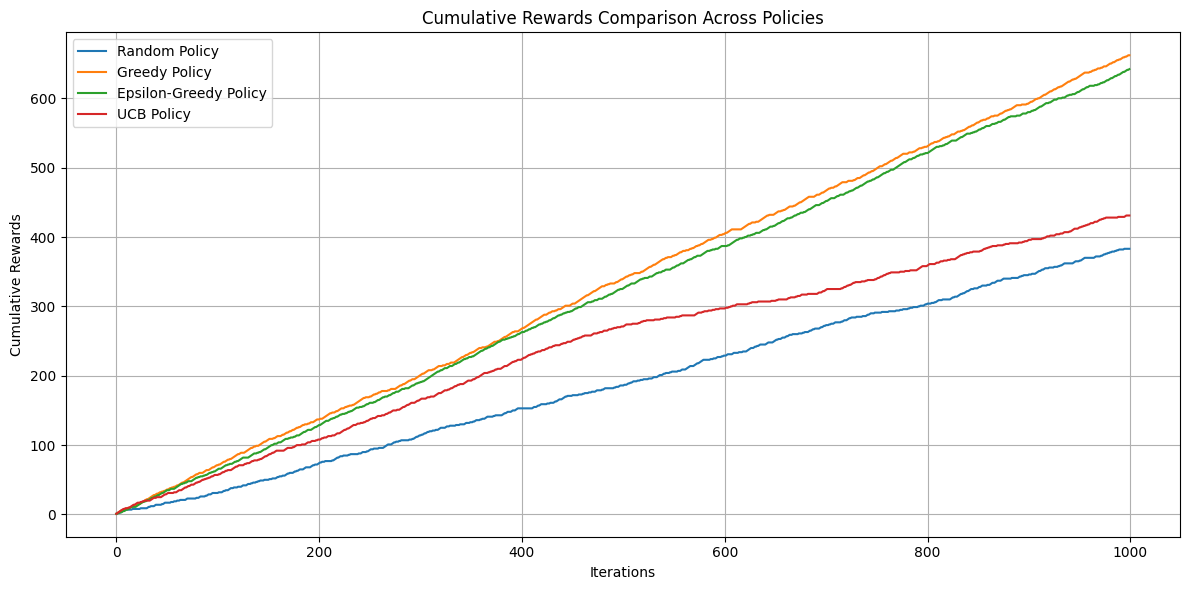

In [71]:
#-----write your code below this line---------

import matplotlib.pyplot as plt
# Plot cumulative rewards
plt.figure(figsize=(12, 6))
plt.plot(random_policy_rewards, label="Random Policy", linewidth=1.5)
plt.plot(greedy_policy_rewards, label="Greedy Policy", linewidth=1.5)
plt.plot(epsilon_greedy_rewards, label="Epsilon-Greedy Policy", linewidth=1.5)
plt.plot(ucb_policy_rewards, label="UCB Policy", linewidth=1.5)
plt.xlabel("Iterations")
plt.ylabel("Cumulative Rewards")
plt.title("Cumulative Rewards Comparison Across Policies")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Conclusion

Determine which policy performs the best based on cumulative reward. Provide a concise conclusion (250 words) summarizing the decision-making process and the trade-offs between exploration and exploitation.

`----write below this line------`